<a href="https://colab.research.google.com/github/JJoshK/-JJoshK-.github.io/blob/master/Flux_Balance_Analysis_Vibrio_natriegens_MVA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cobra

# 모델 불러오기 (파일명이 iECD_1391.json 인지 확인하세요)
model = cobra.io.load_json_model("iECD_1391.json")

# 모델 기본 정보 출력
print(f"모델 이름: {model.id}")
print(f"반응(Reactions) 수: {len(model.reactions)}")
print(f"대사산물(Metabolites) 수: {len(model.metabolites)}")

# 기본 상태에서 시뮬레이션 실행 (보통 세포 성장 최대화가 기본 설정입니다)
solution = model.optimize()
print(f"최적 성장 속도: {solution.objective_value}")

ModuleNotFoundError: No module named 'cobra'

In [2]:
# 모델에서 반응 삭제
model.remove_reactions([
    model.reactions.get_by_id('EX_glc__e'),
    model.reactions.get_by_id('HK1'),
    model.reactions.get_by_id('ATP_synthase')
])

print(f"반응 삭제 후 모델의 반응 수: {len(model.reactions)}")

# 삭제 확인 (에러가 발생해야 정상)
try:
    model.reactions.get_by_id('EX_glc__e')
except KeyError as e:
    print(f"EX_glc__e 반응이 삭제되었습니다: {e}")

NameError: name 'model' is not defined

위 코드를 실행하면 이전에 추가했던 `EX_glc__e`, `HK1`, `ATP_synthase` 반응들이 모델에서 삭제됩니다. 삭제 후 `model.reactions.get_by_id()`로 해당 반응을 찾으려고 하면 `KeyError`가 발생하여 성공적으로 삭제되었음을 확인할 수 있습니다.

In [ ]:
import cobra
from cobra import Metabolite, Reaction

# 새로운 대사산물 정의
glucose = Metabolite('glucose_e', name='Glucose external', compartment='e')
atp = Metabolite('atp_c', name='ATP cytoplasmic', compartment='c')
adp = Metabolite('adp_c', name='ADP cytoplasmic', compartment='c')
pi = Metabolite('pi_c', name='Phosphate cytoplasmic', compartment='c')
glucose_6p = Metabolite('g6p_c', name='Glucose-6-phosphate cytoplasmic', compartment='c')

# 새로운 반응 정의

# 1. 포도당 외부 유입 반응 (Exchange Reaction)
glucose_exchange_reaction = Reaction('EX_glc__e')
glucose_exchange_reaction.name = 'Glucose exchange'
glucose_exchange_reaction.lower_bound = -10.0  # 외부에서 10 단위까지 유입 가능
glucose_exchange_reaction.upper_bound = 1000.0 # 내부에서 외부로 유출 가능 (거의 무제한)
glucose_exchange_reaction.add_metabolites({
glucose: -1.0 # 외부에서 내부로 유입
})

# 2. 해당 과정 첫 번째 단계 (Glycolysis - Hexokinase)
glycolysis_reaction = Reaction('HK1')
glycolysis_reaction.name = 'Hexokinase'
glycolysis_reaction.lower_bound = 0.0 # 정방향만 가능
glycolysis_reaction.upper_bound = 1000.0
glycolysis_reaction.add_metabolites({
glucose: -1.0,
atp: -1.0,
glucose_6p: 1.0,
adp: 1.0
})

# 3. ATP 합성 효소 (예시 반응, 실제 모델에 있는 ATP synthase와 다를 수 있음)
atp_synthase_reaction = Reaction('ATP_synthase')
atp_synthase_reaction.name = 'ATP Synthase'
atp_synthase_reaction.lower_bound = -1000.0 # 양방향 가능
atp_synthase_reaction.upper_bound = 1000.0
atp_synthase_reaction.add_metabolites({
adp: -1.0,
pi: -1.0,
atp: 1.0
})


# 기존 모델에 반응 추가
model.add_reactions([
glucose_exchange_reaction,
glycolysis_reaction,
atp_synthase_reaction
])

print(f"모델에 추가된 반응 수: {len(model.reactions)}")

# 추가된 반응 확인
print("\n새롭게 추가된 반응:")
print(model.reactions.get_by_id('EX_glc__e'))
print(model.reactions.get_by_id('HK1'))
print(model.reactions.get_by_id('ATP_synthase'))

# 새로운 대사산물 확인 (자동으로 추가됨)
print("\n새롭게 추가된 대사산물:")
print(model.metabolites.get_by_id('glucose_e'))
print(model.metabolites.get_by_id('g6p_c'))


모델에 추가된 반응 수: 2744

새롭게 추가된 반응:
EX_glc__e: glucose_e <=> 
HK1: atp_c + glucose_e --> adp_c + g6p_c
ATP_synthase: adp_c + pi_c <=> atp_c

새롭게 추가된 대사산물:
glucose_e
g6p_c


위 코드는 `cobra` 라이브러리를 사용하여 새로운 대사산물(예: `glucose_e`, `atp_c`)과 반응(예: `EX_glc__e`, `HK1`)을 정의하고, 이를 기존 `model` 객체에 추가합니다.

각 반응에 대해 다음과 같은 속성을 설정할 수 있습니다:
- `id`: 반응의 고유 ID
- `name`: 반응의 설명적인 이름
- `lower_bound`, `upper_bound`: 반응 플럭스의 최솟값과 최댓값. 이는 반응이 단방향인지 양방향인지, 그리고 얼마나 많은 양이 이동할 수 있는지를 결정합니다.
- `add_metabolites`: 반응에 참여하는 대사산물과 그 계수(stoichiometric coefficient)를 정의합니다. 계수가 음수이면 반응물, 양수이면 생성물입니다.

모델에 반응을 추가한 후에는 `model.reactions.get_by_id()`를 사용하여 추가된 반응을 확인할 수 있습니다.

In [ ]:
# 'idi'가 포함된 모든 반응의 ID와 이름을 출력
for rxn in model.reactions:
    if 'idi' in rxn.id.lower():
        print(f"ID: {rxn.id} | Name: {rxn.name}")

In [ ]:
# IPP(ipdp_c)가 관여하는 모든 반응 찾기
met = model.metabolites.get_by_id('ipdp_c')
for rxn in met.reactions:
    print(f"ID: {rxn.id} | Equation: {rxn.reaction}")

ID: DMATT | Equation: dmpp_c + ipdp_c --> grdp_c + ppi_c
ID: GRTT | Equation: grdp_c + ipdp_c --> frdp_c + ppi_c
ID: IPDDI | Equation: ipdp_c <=> dmpp_c
ID: OCTDPS | Equation: frdp_c + 5.0 ipdp_c --> octdp_c + 5.0 ppi_c
ID: IPDPS | Equation: h2mb4p_c + h_c + nadh_c --> h2o_c + ipdp_c + nad_c
ID: UDCPDPS | Equation: frdp_c + 8.0 ipdp_c --> 8.0 ppi_c + udcpdp_c


In [ ]:
# HMG-CoA(hmgcoa_c)가 관여하는 모든 반응을 찾아 기존 ID 확인
try:
    met = model.metabolites.get_by_id('hmgcoa_c')
    for rxn in met.reactions:
        print(f"이미 존재하는 반응 ID: {rxn.id} | 식: {rxn.reaction}")
except:
    print("HMG-CoA 대사산물이 모델에 없습니다.")

HMG-CoA 대사산물이 모델에 없습니다.


In [ ]:
# 확인하고 싶은 대사산물 ID 리스트
target_metabolites = ['aaccoa_c', 'hmgcoa_c', 'mev_c', 'mev__R_c', 'mev5p_c', 'mev5pp_c', 'ipdp_c', 'dmapp_c', 'dmpp_c']

print("--- 대사산물 존재 여부 확인 결과 ---")
for met_id in target_metabolites:
    if met_id in model.metabolites:
        met = model.metabolites.get_by_id(met_id)
        print(f"[존재] {met_id} : {met.name}")
    else:
        print(f"[없음] {met_id}")

--- 대사산물 존재 여부 확인 결과 ---
[없음] aaccoa_c
[없음] hmgcoa_c
[없음] mev_c
[없음] mev__R_c
[없음] mev5p_c
[없음] mev5pp_c
[존재] ipdp_c : Isopentenyl diphosphate
[없음] dmapp_c
[존재] dmpp_c : Dimethylallyl diphosphate


In [7]:
import cobra
from cobra import Reaction, Metabolite

# 1. 모델 로드 (업로드한 파일명이 다를 경우 수정하세요)
model = cobra.io.load_json_model("iECD_1391.json")

# 2. 모델에 없는 MVA 경로 중간 대사산물 정의 및 추가
# (ipdp_c와 dmpp_c는 이미 존재하므로 제외하고 새로 정의합니다)
new_metabolites = [
    Metabolite('aaccoa_c', formula='C25H40N7O18P3S', name='Acetoacetyl-CoA', compartment='c'),
    Metabolite('hmgcoa_c', formula='C27H44N7O20P3S', name='Hydroxymethylglutaryl-CoA', compartment='c'),
    Metabolite('mev_c', formula='C6H12O4', name='Mevalonate', compartment='c'),
    Metabolite('mev5p_c', formula='C6H13O7P', name='Mevalonate-5-phosphate', compartment='c'),
    Metabolite('mev5pp_c', formula='C6H14O10P2', name='Mevalonate-5-pyrophosphate', compartment='c'),
    Metabolite('isoprene_e', formula='C5H8', name='Isoprene', compartment='e') # 'c'를 'e'로 변경
]
model.add_metabolites(new_metabolites)

# 3. 7가지 효소 반응 추가
reactions = []

# MvaE (Thiolase): 2 accoa -> aaccoa + coa
r1 = Reaction('MvaE_T')
r1.add_metabolites({model.metabolites.accoa_c: -2, model.metabolites.aaccoa_c: 1, model.metabolites.coa_c: 1})
reactions.append(r1)

# MvaS (HMG-CoA Synthase): accoa + aaccoa + h2o -> hmgcoa + coa + h
r2 = Reaction('MvaS')
r2.add_metabolites({
    model.metabolites.accoa_c: -1, model.metabolites.aaccoa_c: -1, model.metabolites.h2o_c: -1,
    model.metabolites.hmgcoa_c: 1, model.metabolites.coa_c: 1, model.metabolites.h_c: 1
})
reactions.append(r2)

# MvaE (Reductase): hmgcoa + 2 nadph + 2 h -> mev + coa + 2 nadp
r3 = Reaction('MvaE_R')
r3.add_metabolites({
    model.metabolites.hmgcoa_c: -1, model.metabolites.nadph_c: -2, model.metabolites.h_c: -2,
    model.metabolites.mev_c: 1, model.metabolites.coa_c: 1, model.metabolites.nadp_c: 2
})
reactions.append(r3)

# MK (Mevalonate Kinase): mev + atp -> mev5p + adp + h
r4 = Reaction('MK')
r4.add_metabolites({model.metabolites.mev_c: -1, model.metabolites.atp_c: -1, model.metabolites.mev5p_c: 1, model.metabolites.adp_c: 1, model.metabolites.h_c: 1})
reactions.append(r4)

# PMK (Phosphomevalonate Kinase): mev5p + atp -> mev5pp + adp
r5 = Reaction('PMK')
r5.add_metabolites({model.metabolites.mev5p_c: -1, model.metabolites.atp_c: -1, model.metabolites.mev5pp_c: 1, model.metabolites.adp_c: 1})
reactions.append(r5)

# PMD (Mevalonate pyrophosphate decarboxylase): mev5pp + atp -> ipdp_c + adp + pi + co2
r6 = Reaction('PMD')
r6.add_metabolites({
    model.metabolites.mev5pp_c: -1, model.metabolites.atp_c: -1,
    model.metabolites.ipdp_c: 1, model.metabolites.adp_c: 1, model.metabolites.pi_c: 1, model.metabolites.co2_c: 1
})
reactions.append(r6)

# ISPS (Isoprene Synthase): dmpp_c -> isoprene_e + ppi (기존 dmpp_c ID 사용) # isoprene_c를 isoprene_e로 변경
r7 = Reaction('ISPS')
r7.add_metabolites({model.metabolites.dmpp_c: -1, model.metabolites.isoprene_e: 1, model.metabolites.ppi_c: 1}) # isoprene_c를 isoprene_e로 변경
reactions.append(r7)

model.add_reactions(reactions)

# 4. 기존 IDI(IPDDI) 반응 가역성 확보 (이미 되어있지만 확인 차원)
model.reactions.IPDDI.lower_bound = -1000.0

# 5. 시뮬레이션 설정: 이소프렌 배출 반응 추가 및 목적함수 설정
# 'id' 인수는 add_boundary에 지원되지 않으므로 제거합니다.
model.add_boundary(model.metabolites.isoprene_e, type='exchange') # isoprene_c를 isoprene_e로 변경
model.objective = 'ISPS'

# 6. 결과 출력
solution = model.optimize()
print(f"--- 시뮬레이션 결과 ---")
if solution.status == 'optimal':
    print(f"최대 이소프렌 생산 수율: {solution.objective_value:.4f} mmol/gDCW/hr")
else:
    print("최적해를 찾지 못했습니다. 경로 연결을 확인하세요.")

--- 시뮬레이션 결과 ---
최대 이소프렌 생산 수율: 8.1983 mmol/gDCW/hr


In [8]:
# MEP 경로 및 전자 전달 관련 키워드 검색
mep_genes = ['dxs', 'dxr', 'ispG', 'ispH', 'fldA', 'petF', 'petH']
found_rxns = []

for rxn in model.reactions:
    # 유전자 정보나 이름에서 키워드 검색
    if any(key in rxn.gene_reaction_rule.lower() for key in mep_genes) or \
       any(key in rxn.id.lower() for key in mep_genes):
        found_rxns.append(rxn)

for r in found_rxns:
    print(f"ID: {r.id} | Name: {r.name} | Equation: {r.reaction}")

In [4]:
!pip install cobra

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.8/141.8 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 82.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.1/118.1 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 73.8 MB/s eta 0:00:00


In [11]:
# MEP 경로 및 전자 전달 관련 키워드 검색
mep_genes = ['dxs', 'dxr', 'ispG', 'ispH', 'fldA', 'petF', 'petH']
found_rxns = []

for rxn in model.reactions:
    # 유전자 정보나 이름에서 키워드 검색
    if any(key in rxn.gene_reaction_rule.lower() for key in mep_genes) or \
       any(key in rxn.id.lower() for key in mep_genes):
        found_rxns.append(rxn)

for r in found_rxns:
    print(f"ID: {r.id} | Name: {r.name} | Equation: {r.reaction}")

In [12]:
# 1. 반응 이름(Name)에서 키워드로 검색 (가장 확실함)
keywords = ['deoxyxylulose', 'erythritol', 'methylbutenyl', 'flavodoxin', 'ferredoxin']
print("--- 키워드 기반 반응 검색 결과 ---")
for rxn in model.reactions:
    if any(k in rxn.name.lower() for k in keywords):
        print(f"ID: {rxn.id} | Name: {rxn.name}")

print("\n" + "="*50 + "\n")

# 2. 유전자 객체(Genes)에서 이름 검색
print("--- 유전자 이름 검색 결과 ---")
for gene in model.genes:
    # 유전자 이름이나 별칭이 정의되어 있는지 확인
    if any(k in gene.id.lower() for k in ['dxs', 'dxr', 'ispg', 'isph', 'flda', 'petf', 'peth']):
        print(f"Gene ID: {gene.id} | Name: {gene.name}")

--- 키워드 기반 반응 검색 결과 ---
ID: CDPMEK | Name: 4-(cytidine 5'-diphospho)-2-C-methyl-D-erythritol kinase
ID: FLDR2 | Name: Flavodoxin reductase (NADPH)
ID: MECDPDH5 | Name: 2C-methyl-D-erythritol 2,4 cyclodiphosphate dehydratase
ID: MECDPS | Name: 2-C-methyl-D-erythritol 2,4-cyclodiphosphate synthase
ID: MEPCT | Name: 2-C-methyl-D-erythritol 4-phosphate cytidylyltransferase
ID: RNTR1c2 | Name: Ribonucleoside-triphosphate reductase (ATP) (flavodoxin)
ID: RNTR2c2 | Name: Ribonucleoside-triphosphate reductase (GTP) (flavodoxin)
ID: RNTR3c2 | Name: Ribonucleoside-triphosphate reductase (CTP) (flavodoxin)
ID: RNTR4c2 | Name: Ribonucleoside-triphosphate reductase (UTP) (flavodoxin)
ID: PFOR | Name: Pyruvate flavodoxin oxidoreductase
ID: FLDR | Name: Flavodoxin reductase (NADPH)
ID: MECDPDH2 | Name: 2C-methyl-D-erythritol 2,4 cyclodiphosphate dehydratase


--- 유전자 이름 검색 결과 ---


In [13]:
# 1. 예상 ID로 직접 확인
expected_ids = ['DXS', 'DXPRIi']
for rid in expected_ids:
    if rid in model.reactions:
        rxn = model.reactions.get_by_id(rid)
        print(f"ID: {rxn.id} | Name: {rxn.name} | Equation: {rxn.reaction}")
    else:
        print(f"ID {rid}를 모델에서 찾을 수 없습니다.")

# 2. 유전자 Locus Tag로 검색 (가장 정확함)
# E. coli BL21(DE3)에서 dxs는 ECD_00414, dxr은 ECD_00164입니다.
locus_tags = {'dxs': 'ECD_00414', 'dxr': 'ECD_00164'}
for common_name, tag in locus_tags.items():
    try:
        gene = model.genes.get_by_id(tag)
        for rxn in gene.reactions:
            print(f"[{common_name}] 관련 반응 ID: {rxn.id} | Name: {rxn.name}")
    except:
        print(f"유전자 {tag}({common_name})를 찾을 수 없습니다.")

ID DXS를 모델에서 찾을 수 없습니다.
ID: DXPRIi | Name: 1-deoxy-D-xylulose reductoisomerase | Equation: dxyl5p_c + h_c + nadph_c --> 2me4p_c + nadp_c
[dxs] 관련 반응 ID: TTRCYCtpp | Name: Tetracycline transport via TolC system
[dxs] 관련 반응 ID: INDOLEt2pp | Name: Indole transport via proton symport, irreversible (periplasm)
[dxs] 관련 반응 ID: DOXRBCNtpp | Name: Doxorubicin transport via TolC system
[dxs] 관련 반응 ID: MINCYCtpp | Name: Minocycline transport via TolC system
[dxs] 관련 반응 ID: CMtpp | Name: Chloramphenicol transport via TolC system
[dxs] 관련 반응 ID: NOVBCNtpp | Name: Novobiocin transport via TolC system
[dxs] 관련 반응 ID: RFAMPtpp | Name: Rifampin transport via TolC system
[dxs] 관련 반응 ID: FUSAtpp | Name: Fusidic acid transport via TolC system
[dxr] 관련 반응 ID: THDPS | Name: Tetrahydrodipicolinate succinylase


In [15]:
# 'dxyl5p_c'를 생성하는 반응(Dxs에 해당)을 찾습니다.
met = model.metabolites.get_by_id('dxyl5p_c')

print("--- dxs 후보 반응 검색 결과 ---")
for rxn in met.reactions:
    # 해당 대사산물의 계수가 양수(+)이면 생성 반응입니다.
    if rxn.get_coefficient('dxyl5p_c') > 0:
        print(f"ID: {rxn.id} | Name: {rxn.name} | Equation: {rxn.reaction}")

--- dxs 후보 반응 검색 결과 ---
ID: DXPS | Name: 1-deoxy-D-xylulose 5-phosphate synthase | Equation: g3p_c + h_c + pyr_c --> co2_c + dxyl5p_c
ID: DXYLK | Name: 1-Deoxy-D-xylulose kinase | Equation: atp_c + dxyl_c --> adp_c + dxyl5p_c + h_c


In [17]:
import cobra
from cobra import Reaction, Metabolite

# 1. 모델 로드
model = cobra.io.load_json_model("iECD_1391.json")

# 2. MVA 경로 중간 대사산물 및 반응 추가 (이전 단계와 동일)
new_mets = [
    Metabolite('aaccoa_c', formula='C25H40N7O18P3S', name='Acetoacetyl-CoA', compartment='c'),
    Metabolite('hmgcoa_c', formula='C27H44N7O20P3S', name='Hydroxymethylglutaryl-CoA', compartment='c'),
    Metabolite('mev_c', formula='C6H12O4', name='Mevalonate', compartment='c'),
    Metabolite('mev5p_c', formula='C6H13O7P', name='Mevalonate-5-phosphate', compartment='c'),
    Metabolite('mev5pp_c', formula='C6H14O10P2', name='Mevalonate-5-pyrophosphate', compartment='c'),
    Metabolite('isoprene_e', formula='C5H8', name='Isoprene', compartment='e') # 구획을 e로 설정
]
model.add_metabolites(new_mets)

# MVA 7단계 반응 추가
mva_reactions = []

# MvaE (Thiolase): 2 accoa -> aaccoa + coa
r1 = Reaction('MvaE_T')
r1.add_metabolites({model.metabolites.accoa_c: -2, model.metabolites.aaccoa_c: 1, model.metabolites.coa_c: 1})
mva_reactions.append(r1)

# MvaS (HMG-CoA Synthase): accoa + aaccoa + h2o -> hmgcoa + coa + h
r2 = Reaction('MvaS')
r2.add_metabolites({
    model.metabolites.accoa_c: -1, model.metabolites.aaccoa_c: -1, model.metabolites.h2o_c: -1,
    model.metabolites.hmgcoa_c: 1, model.metabolites.coa_c: 1, model.metabolites.h_c: 1
})
mva_reactions.append(r2)

# MvaE (Reductase): hmgcoa + 2 nadph + 2 h -> mev + coa + 2 nadp
r3 = Reaction('MvaE_R')
r3.add_metabolites({
    model.metabolites.hmgcoa_c: -1, model.metabolites.nadph_c: -2, model.metabolites.h_c: -2,
    model.metabolites.mev_c: 1, model.metabolites.coa_c: 1, model.metabolites.nadp_c: 2
})
mva_reactions.append(r3)

# MK (Mevalonate Kinase): mev + atp -> mev5p + adp + h
r4 = Reaction('MK')
r4.add_metabolites({model.metabolites.mev_c: -1, model.metabolites.atp_c: -1, model.metabolites.mev5p_c: 1, model.metabolites.adp_c: 1, model.metabolites.h_c: 1})
mva_reactions.append(r4)

# PMK (Phosphomevalonate Kinase): mev5p + atp -> mev5pp + adp
r5 = Reaction('PMK')
r5.add_metabolites({model.metabolites.mev5p_c: -1, model.metabolites.atp_c: -1, model.metabolites.mev5pp_c: 1, model.metabolites.adp_c: 1})
mva_reactions.append(r5)

# PMD (Mevalonate pyrophosphate decarboxylase): mev5pp + atp -> ipdp_c + adp + pi + co2
r6 = Reaction('PMD')
r6.add_metabolites({
    model.metabolites.mev5pp_c: -1, model.metabolites.atp_c: -1,
    model.metabolites.ipdp_c: 1, model.metabolites.adp_c: 1, model.metabolites.pi_c: 1, model.metabolites.co2_c: 1
})
mva_reactions.append(r6)

# ISPS (Isoprene Synthase): dmpp_c -> isoprene_e + ppi (기존 dmpp_c ID 사용)
r7 = Reaction('ISPS')
r7.add_metabolites({model.metabolites.dmpp_c: -1, model.metabolites.isoprene_e: 1, model.metabolites.ppi_c: 1})
mva_reactions.append(r7)

model.add_reactions(mva_reactions)

# 3. MEP 경로 과발현 설정 (확인된 ID 반영)
# dxs=DXPS, dxr=DXPRIi, ispG=MECDPDH2, ispH=IPDPS, fldA=FLDR
mep_overexpress_ids = ['DXPS', 'DXPRIi', 'MEPCT', 'CDPMEK', 'MECDPS', 'MECDPDH2', 'IPDPS', 'FLDR']

print("--- MEP 경로 과발현 적용 현황 ---")
for rid in mep_overexpress_ids:
    if rid in model.reactions:
        rxn = model.reactions.get_by_id(rid)
        rxn.upper_bound = 1000.0
        rxn.lower_bound = 0.0
        print(f"[OK] {rid} 과발현 설정 완료")

# 4. 전자 전달계 (petF, petH) 지원을 위한 페레독신 환원 반응 점검
# petH가 NADPH를 사용하여 fdx_ox를 fdx_red로 바꾼다고 가정
if 'PETH' not in model.reactions:
    # 모델 내 fdx_ox_c, fdx_red_c 존재 여부 확인 후 추가
    try:
        r_peth = Reaction('PETH')
        r_peth.add_metabolites({
            model.metabolites.nadph_c: -1,
            model.metabolites.fdx_ox_c: -2, # Stoichiometry는 모델에 따라 조정
            model.metabolites.nadp_c: 1,
            model.metabolites.fdx_red_c: 2,
            model.metabolites.h_c: 1
        })
        model.add_reactions([r_peth])
        print("[추가] petH (Ferredoxin-NADP reductase) 반응")
    except:
        print("[참고] 모델 내 페레독신 ID가 달라 petH 추가를 건너뜁니다.")

# 5. 시나리오 실행: 이소프렌 최대화
model.add_boundary(model.metabolites.isoprene_e, type='exchange', reaction_id='EX_isoprene_e')
model.objective = 'ISPS'

solution = model.optimize()

print("\n" + "="*40)
print(f"MVA + MEP 통합 이론적 최대 수율: {solution.objective_value:.4f} mmol/gDCW/hr")
print("="*40)

--- MEP 경로 과발현 적용 현황 ---
[OK] DXPS 과발현 설정 완료
[OK] DXPRIi 과발현 설정 완료
[OK] MEPCT 과발현 설정 완료
[OK] CDPMEK 과발현 설정 완료
[OK] MECDPS 과발현 설정 완료
[OK] MECDPDH2 과발현 설정 완료
[OK] IPDPS 과발현 설정 완료
[OK] FLDR 과발현 설정 완료
[참고] 모델 내 페레독신 ID가 달라 petH 추가를 건너뜁니다.

MVA + MEP 통합 이론적 최대 수율: 8.1983 mmol/gDCW/hr


In [18]:
# 어느 경로로 탄소가 흐르는지 확인
print(f"MVA 경로(MvaE) 플럭스: {solution.fluxes['MvaE_T']:.4f}")
print(f"MEP 경로(DXPS) 플럭스: {solution.fluxes['DXPS']:.4f}")

MVA 경로(MvaE) 플럭스: 0.0000
MEP 경로(DXPS) 플럭스: 8.1983


In [19]:
# 1. 시뮬레이션 실행
solution = model.optimize()

# 2. 섀도 가격(Shadow Price) 추출 및 정렬
shadow_prices = solution.shadow_prices
top_bottlenecks = shadow_prices.sort_values(ascending=False).head(5)

print("--- 이소프렌 생산 증대를 위한 핵심 병목 물질 ---")
print(top_bottlenecks)

# 만약 nadph_c의 값이 매우 높다면, 보조인자 공급이 병목입니다.

--- 이소프렌 생산 증대를 위한 핵심 병목 물질 ---
4hbz_c      5.949153
udcpdp_p    3.394068
udcpdp_c    3.394068
udcpp_c     3.394068
uLa4n_c     3.394068
Name: shadow_prices, dtype: float64


/usr/local/lib/python3.12/dist-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


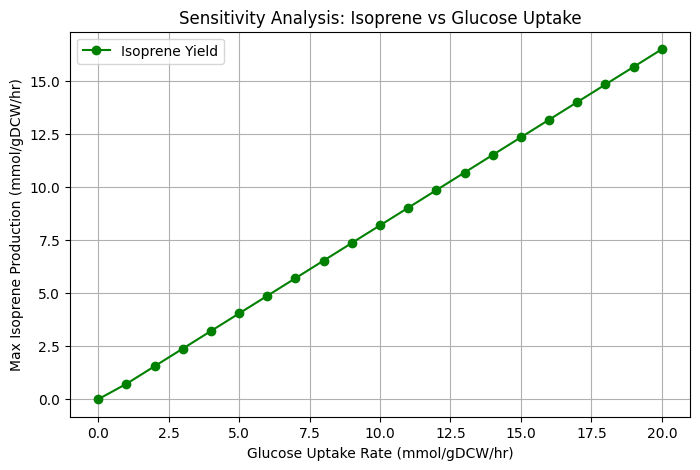

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# 1. 글루코스 흡수량 변화에 따른 수율 변화 분석
glucose_rates = np.linspace(0, 20, 21) # 0부터 20까지 변화
isoprene_yields = []

for rate in glucose_rates:
    with model:
        # 글루코스 흡수 속도 제한 변경
        model.reactions.EX_glc__D_e.lower_bound = -rate
        sol = model.optimize()
        isoprene_yields.append(sol.objective_value if sol.status == 'optimal' else 0)

# 2. 그래프 시각화
plt.figure(figsize=(8, 5))
plt.plot(glucose_rates, isoprene_yields, 'g-o', label='Isoprene Yield')
plt.title('Sensitivity Analysis: Isoprene vs Glucose Uptake')
plt.xlabel('Glucose Uptake Rate (mmol/gDCW/hr)')
plt.ylabel('Max Isoprene Production (mmol/gDCW/hr)')
plt.grid(True)
plt.legend()
plt.show()

In [22]:
# 1. 가상의 NADPH 공급 반응 추가 (NADP + H -> NADPH)
if 'NADPH_supply' not in model.reactions:
    supply_rxn = Reaction('NADPH_supply')
    supply_rxn.add_metabolites({
        model.metabolites.nadp_c: -1,
        model.metabolites.h_c: -1,
        model.metabolites.nadph_c: 1
    })
    model.add_reactions([supply_rxn])

# 2. 외부 NADPH 공급량 변화에 따른 수율 관찰
nadph_supply_rates = np.linspace(0, 50, 11)
yields_with_nadph = []

for supply in nadph_supply_rates:
    with model:
        # 가상 공급 반응의 플럭스를 고정
        model.reactions.NADPH_supply.lower_bound = supply
        model.reactions.NADPH_supply.upper_bound = supply
        sol = model.optimize()
        yields_with_nadph.append(sol.objective_value)

# 3. 결과 출력
for s, y in zip(nadph_supply_rates, yields_with_nadph):
    print(f"추가 NADPH 공급: {s} -> 이소프렌 수율: {y:.4f}")

추가 NADPH 공급: 0.0 -> 이소프렌 수율: 8.1983
추가 NADPH 공급: 5.0 -> 이소프렌 수율: 8.6644
추가 NADPH 공급: 10.0 -> 이소프렌 수율: 9.1193
추가 NADPH 공급: 15.0 -> 이소프렌 수율: 9.5119
추가 NADPH 공급: 20.0 -> 이소프렌 수율: 9.8932
추가 NADPH 공급: 25.0 -> 이소프렌 수율: 10.2234
추가 NADPH 공급: 30.0 -> 이소프렌 수율: 10.5338
추가 NADPH 공급: 35.0 -> 이소프렌 수율: 10.8441
추가 NADPH 공급: 40.0 -> 이소프렌 수율: 11.1545
추가 NADPH 공급: 45.0 -> 이소프렌 수율: 11.4648
추가 NADPH 공급: 50.0 -> 이소프렌 수율: 11.7752
